Request for John

In [1]:
import geopandas as gpd
from dem_stitcher.geojson_io import read_geojson_gzip
from tqdm import tqdm
import pandas as pd
import asf_search as asf
import datetime
import matplotlib.pyplot as plt

# Tiles

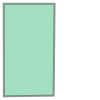

In [2]:
df_aoi = gpd.read_file('EDEN_S1_Sample_Area/EDEN_S1_Sample_Area.shp')
geo = df_aoi.geometry.unary_union
geo

In [3]:
df_mgrs = read_geojson_gzip('s2_mgrs_grid.geojson.gzip')
df_mgrs.head()

,geometry,type,identifier
0,"MULTIPOLYGON Z (((180.00000 -73.05974 0.00000,...",S2,01CCV
1,"MULTIPOLYGON Z (((180.00000 -83.80855 0.00000,...",S2,01CDH
2,"MULTIPOLYGON Z (((180.00000 -82.91344 0.00000,...",S2,01CDJ
3,"MULTIPOLYGON Z (((180.00000 -82.01866 0.00000,...",S2,01CDK
4,"MULTIPOLYGON Z (((180.00000 -81.12317 0.00000,...",S2,01CDL


In [5]:
df_mgrs_aoi = df_mgrs[df_mgrs.intersects(geo)].reset_index(drop=True)
df_mgrs_aoi

,geometry,type,identifier
0,"MULTIPOLYGON Z (((-81.99389 25.31338 0.00000, ...",S2,17RMH
1,"MULTIPOLYGON Z (((-82.00143 26.21644 0.00000, ...",S2,17RMJ
2,"MULTIPOLYGON Z (((-82.00935 27.11884 0.00000, ...",S2,17RMK
3,"MULTIPOLYGON Z (((-81.00020 25.31673 0.00000, ...",S2,17RNH
4,"MULTIPOLYGON Z (((-81.00020 26.21993 0.00000, ...",S2,17RNJ
5,"MULTIPOLYGON Z (((-81.00020 27.12247 0.00000, ...",S2,17RNK


In [27]:
TILES = df_mgrs_aoi.identifier.tolist()
TILES

['17RMH', '17RMJ', '17RMK', '17RNH', '17RNJ', '17RNK']

# Request

```
March 2022
May 2022
August 2022
November 2022
March 2023
April 2023
August 2023
November 2023
```

In [9]:
START_TIME = datetime.datetime(2022, 3, 1)
STOP_TIME = datetime.datetime(2023, 11, 1)

def get_df(tile: str) -> gpd.GeoDataFrame:
    geo = df_mgrs_aoi[df_mgrs_aoi.identifier == tile].geometry.tolist()[0]
    scenes = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
            intersectsWith=geo.wkt,
            beamMode=[asf.BEAMMODE.IW],
            processingLevel=[asf.PRODUCT_TYPE.SLC],
            start=START_TIME,
            end=STOP_TIME,
        )
    
    df = gpd.GeoDataFrame.from_features(scenes.geojson(), crs='EPSG:4326')
    df['startTime'] =  pd.to_datetime(df['startTime'])
    df['date_str'] = df['startTime'].dt.date.map(str)
    
    df_d = df.dissolve(by=['date_str', 'pathNumber'], as_index=False)

    int_geo = df_d.geometry.intersection(geo)
    perc_overlap = int_geo.area / geo.area

    admissible_dates = df_d[perc_overlap > .99].date_str.tolist()
    admissible_tracks = df_d[perc_overlap > .99].pathNumber.tolist()

    df_f = df[df.date_str.isin(admissible_dates) & df.pathNumber.isin(admissible_tracks)]
    df_f['mgrs_tile_id'] = tile
    return df_f



In [10]:
dfs = list(map(get_df, tqdm(TILES)))
df_all = pd.concat(dfs, axis=0)

  0%|                                                                              | 0/6 [00:00<?, ?it/s]/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_2484/1865332660.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perc_overlap = int_geo.area / geo.area
 17%|███████████▋                                                          | 1/6 [00:01<00:08,  1.65s/it]/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_2484/1865332660.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perc_overlap = int_geo.area / geo.area
/Users/cmarshak/miniforge3/envs/dswx_val/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [11]:
df_all = df_all.drop_duplicates(subset='fileID')

In [12]:
df_all.shape

(139, 27)

In [22]:
df_all['acq_dt'] = pd.to_datetime(df_all.startTime)
df_all['acq_date'] = df_all['acq_dt'].dt.date
df_filtered = df_all[df_all['acq_dt'].dt.month.isin([3, 4, 5, 8, 11])].reset_index(drop=True)
df_filtered.shape

(64, 29)

In [23]:
df_filtered['acq_date'].unique().tolist()

[datetime.date(2023, 8, 22),
 datetime.date(2023, 8, 10),
 datetime.date(2023, 5, 6),
 datetime.date(2023, 4, 24),
 datetime.date(2023, 4, 12),
 datetime.date(2023, 3, 31),
 datetime.date(2023, 3, 19),
 datetime.date(2023, 3, 7),
 datetime.date(2022, 11, 19),
 datetime.date(2022, 11, 7),
 datetime.date(2022, 8, 27),
 datetime.date(2022, 8, 15),
 datetime.date(2022, 8, 3),
 datetime.date(2022, 5, 11),
 datetime.date(2022, 4, 29),
 datetime.date(2022, 4, 17),
 datetime.date(2022, 4, 5),
 datetime.date(2022, 3, 24),
 datetime.date(2022, 3, 12),
 datetime.date(2023, 5, 30),
 datetime.date(2023, 5, 18),
 datetime.date(2022, 11, 10)]

In [24]:
df_filtered.to_csv('jwjones_eden_request.csv')

In [25]:
df_filtered.pathNumber.unique()

array([48, 84])

<Axes: >

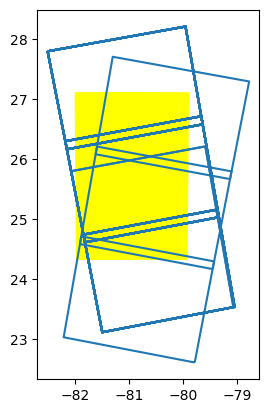

In [26]:
fig, ax = plt.subplots()
df_filtered.exterior.plot(ax=ax)
df_mgrs_aoi.plot(ax=ax, color='yellow')